# Predicción valor del oro semanal

Al parecer, en muchas páginas en las que se descarga el precio del oro diario, se actualizan cada semana, por lo cuál, un modelo que haga una predicción diaria, no será útil.

En este documento se presentará un modelo que hace una predicción del promedio semanal del precio del oro.

$$y_i = \alpha + \beta_i*X_i + \epsilon$$

En dónde:
 - yi = Promedio del precio del oro de la semana _i_
 - Bi = Coeficientes de la regresión
 - Xi = Variables de la regresión

# Fuentes de datos

Se usarán los siguientes datos:
 - **Históricos diarios - Precio Oro en dólares:** https://www.quandl.com/data/WGC/GOLD_DAILY_USD-Gold-Prices-Daily-Currency-USD
 - **Históricos diarios - Predio del dólar:** http://www.anterior.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=6&accion=consultarCuadro&idCuadro=CF373&locale=es

Se obtendrán los valores del precio del dólar, con el único de fin de usar las fechas como referencia, ya que el dólar sólo se cotiza en los días hábiles mexicanos.

# Librerías

In [1]:
library(dplyr)
library(ggplot2)
library(readr)
library(forcats)
library(plotly)
library(repr)
library(mltools)
library(data.table)
library(rvest)
library(stringi)
library(zoo)
library(PMwR)

Warning message:
“package ‘dplyr’ was built under R version 3.5.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Warning message:
“package ‘repr’ was built under R version 3.5.2”Warning message:
“package ‘data.table’ was built under R version 3.5.2”
Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Loading required package: xml2

Attaching package: ‘rvest’

The following object is masked from ‘package:readr’:

    guess_encoding

Warning message:
“package ‘stringi’ was built under R version 3.5.2”Warning message:
“package ‘zoo’ was built unde

# Lectura de datos

## Históricos oro

In [2]:
gold_price <- read_csv("/Users/darias/Documents/GoldPrice/Data/WGC-GOLD_DAILY_USD.csv")

names(gold_price) <- c('date', 'goldprice')

gold_price %>%
 arrange(date) -> gold_price

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Value = col_double()
)


## Históricos dólar

In [3]:
dolar_price <- read_csv("/Users/darias/Documents/GoldPrice/Data/Consulta_20190502-142917176.csv", 
    skip = 17)

names(dolar_price) <- c('date', 'dolarprice')

dolar_price %>%
 mutate(date = paste0(substr(date,7,10),
                     '-',
                     substr(date,4,5),
                     '-',
                     substr(date,1,2))) %>%
 mutate(date = as.Date(date)) -> dolar_price

Parsed with column specification:
cols(
  Fecha = col_character(),
  SF63528 = col_double()
)


# Homologar datos

Se dejarán los datos con las mismas fechas de inicio y fin

In [4]:
max_date <- min(max(gold_price$date), max(dolar_price$date))
min_date <- max(min(gold_price$date), min(dolar_price$date))

dolar_price %>%
 filter(date >= min_date) %>%
 filter(date <= max_date) -> dolar_price

gold_price %>%
 filter(date >= min_date) %>%
 filter(date <= max_date) -> gold_price

Se hace de nuevo por si llegó a haber algún desfase

In [5]:
max_date <- min(max(gold_price$date), max(dolar_price$date))
min_date <- max(min(gold_price$date), min(dolar_price$date))

dolar_price %>%
 filter(date >= min_date) %>%
 filter(date <= max_date) -> dolar_price

gold_price %>%
 filter(date >= min_date) %>%
 filter(date <= max_date) -> gold_price

# Join de Dólar y Oro

Se pondrán los datos en un único data frame, usando como referencia las fechas de los precios del dólar, ya que respetan los días inhábiles de México

Por lo cuál posteriormente del join, se quitará el valor del dólar

In [6]:
dolar_price %>%
 left_join(gold_price, by = 'date') %>%
 select(-dolarprice) -> data

# Limpiar datos

Se quitan datos con NAs, y se dejarán sólo fechas a partir del 2010

In [7]:
data %>%
 filter(!is.na(goldprice)) -> data

In [8]:
data %>%
 filter(date >= as.Date('2010-01-01')) -> data

# Ingeniería de datos

Se creará:
 - Promedio semanal del precio del oro
 - Desviación estandar semanal del precio del oro
 - Log Rendimientos
 - Rezagos
 - Medias Móviles
 - Rachas
 - Dummies de mes
 - Dummies de número de semana del mes

## Promedio semanal

Se creará el promedio semanal del precio del oro.

In [9]:
data %>%
 mutate(week = paste0(year(date),'-',format(date, '%W'))) %>%
 group_by(week) %>%
 summarise(min_date = min(date),
           max_date = max(date),
           avg_gold = mean(goldprice, na.rm = TRUE),
           std_gold = sd(goldprice, na.rm = TRUE)) %>%
 arrange(as.numeric(gsub('-','',week))) %>%
 filter(!is.na(std_gold)) %>%
 mutate(mes = month(max_date)) %>%
 mutate(mes = ifelse(mes == 1, 'Ene', mes),
        mes = ifelse(mes == 2, 'Feb', mes),
        mes = ifelse(mes == 3, 'Mar', mes),
        mes = ifelse(mes == 4, 'Abr', mes),
        mes = ifelse(mes == 5, 'May', mes),
        mes = ifelse(mes == 6, 'Jun', mes),
        mes = ifelse(mes == 7, 'Jul', mes),
        mes = ifelse(mes == 8, 'Ago', mes),
        mes = ifelse(mes == 9, 'Sep', mes),
        mes = ifelse(mes == 10, 'Oct', mes),
        mes = ifelse(mes == 11, 'Nov', mes),
        mes = ifelse(mes == 12, 'Dic', mes)) -> data

In [10]:
head(data)

week    min_date   max_date   avg_gold std_gold  mes
1 2010-01 2010-01-04 2010-01-08 1126.350  3.931444 Ene
2 2010-02 2010-01-11 2010-01-15 1139.550 12.289986 Ene
3 2010-03 2010-01-18 2010-01-22 1116.000 20.816910 Ene
4 2010-04 2010-01-25 2010-01-29 1089.950  7.016498 Ene
5 2010-05 2010-02-02 2010-02-05 1091.875 26.671224 Feb
6 2010-06 2010-02-08 2010-02-12 1072.600  6.838768 Feb

## Rendimientos de precio del oro

Se obtendrá el _log rendimiento_ del oro, como una variable del modelo.

$$Rend_i = \ln{\frac{PrecioOro_{t+1}}{PrecioOro_{t}}}$$

### Función

Se crea función que agrega una columna con los rendimientos del oro.

Esta función tiene un indicador, el cual funciona para saber si se agrega a un _Data frame_ para entrenar un modelo o para hacer una predicción.

Si es para hacer una predicción, se hace con un _lag_ menos, ya que en una predicción se busca usar los datos más recientes para hacer una predicción a futuro.

In [11]:
rend_func <- function(df, col_ref, nom_col_nueva, ind_train){
  
  # Para predict se quita un lag
  
  if(ind_train == TRUE){
    df %>%
      mutate_(aux1 = col_ref) %>%
      mutate(aux2  = lag(aux1)) %>%
      mutate(aux3  = log(aux2/lag(aux2))) %>%
      select(-aux1, -aux2) -> d 
  } else{
    df %>%
      mutate_(aux1 = col_ref) %>%
      mutate(aux2  = aux1) %>%
      mutate(aux3  = log(aux1/lag(aux2))) %>%
      select(-aux1, -aux2) -> d
  }
  
  names(d)[which(names(d) == 'aux3')] <- nom_col_nueva
  
  return(d)
}

### Se agregan rendimientos

Se aplica la función para agregar rendimientos

In [12]:
data <- rend_func(data, 'avg_gold', 'rend', ind_train = TRUE)

Warning message:
“mutate_() is deprecated. 
Please use mutate() instead

The 'programming' vignette or the tidyeval book can help you
to program with mutate() : https://tidyeval.tidyverse.org
This warning is displayed once per session.”

## Rezagos

Se agregarán rezagos de:
 - Promedio del precio del oro
 - Desviación estandar del precio del oro
 - Rendimientos del oro
 
A 1,2,3,4,6 y 8 semanas

Se agregará rezafo de 1 semana para el mes

### Función

Se creará una función que agregar una columna con los rezagos a _X_ semanas de una columnas específica.

Tendrá la misma consideración del indicador de si es una _data frame_ para entrenar o para predecir

In [13]:
rez_func <- function(df, col_ref, nom_col_nueva, num_rezagos, ind_train){
  # Cuando es para predict, se quita un lag
  if(ind_train == TRUE){
    # Se crea vector con código de número de lags a hacer y sus paréntesis de cierre para train
    num_lags  <- rep('lag(',num_rezagos)
    close_par <- rep(')', num_rezagos)
  } else {
    # Se crea vector con código de número de lags a hacer y sus paréntesis de cierre para predict
    num_lags  <- rep('lag(',num_rezagos-1)
    close_par <- rep(')', num_rezagos-1)
  }
  
  # Se convierten a un sólo caracter
  num_lags  <- stri_paste(num_lags, collapse = '')
  close_par <- stri_paste(close_par, collapse = '')
  
  # Se pega el código
  cod <- paste0(num_lags, 'aux', close_par)
  
  # Se crea la columna nueva
  df %>%
    mutate_(aux = col_ref) %>%
    mutate_(aux = cod) -> d
  
  names(d)[which(names(d) == 'aux')] <- nom_col_nueva
  
  return(d)
}

### Agregan Rezagos

In [14]:
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_1s',  1,  TRUE)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_2s',  2,  TRUE)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_3s',  3,  TRUE)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_4s',  4,  TRUE)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_6s',  6,  TRUE)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_8s',  8,  TRUE)

In [15]:
data <- rez_func(data, 'std_gold', 'rez_std_gold_1s',  1,  TRUE)
data <- rez_func(data, 'std_gold', 'rez_std_gold_2s',  2,  TRUE)
data <- rez_func(data, 'std_gold', 'rez_std_gold_3s',  3,  TRUE)
data <- rez_func(data, 'std_gold', 'rez_std_gold_4s',  4,  TRUE)
data <- rez_func(data, 'std_gold', 'rez_std_gold_6s',  6,  TRUE)
data <- rez_func(data, 'std_gold', 'rez_std_gold_8s',  8,  TRUE)

In [16]:
data <- rez_func(data, 'rend', 'rez_rend_gold_1s',  1,  TRUE)
data <- rez_func(data, 'rend', 'rez_rend_gold_2s',  2,  TRUE)
data <- rez_func(data, 'rend', 'rez_rend_gold_3s',  3,  TRUE)
data <- rez_func(data, 'rend', 'rez_rend_gold_4s',  4,  TRUE)
data <- rez_func(data, 'rend', 'rez_rend_gold_6s',  6,  TRUE)
data <- rez_func(data, 'rend', 'rez_rend_gold_8s',  8,  TRUE)

In [17]:
data %>%
 mutate(mes = lag(mes)) -> data

## Medias Móviles

Se obtendrán las medias móviles a diferentes tiempos para:
 - Promedio de precio de oro
 - Desviación estandar del precio del oro
 - Rendimiento del oro
 
Con el indicador si para _train_ o _predict_ el _Data frame_

Media Móvil de una variable de _T_ tiempos

$$MediaMóvil_i = \frac{1}{n}\sum_{i=1}^{n} Variable_{t-i}$$

### Función

In [18]:
mm_func <- function(df, col_ref, nom_col_nueva, t, ind_train){
  # Cuando es para predict se quita un lag para calcular las medias móviles
  if(ind_train == TRUE){
    # Se crea el vector de medias móviles a "t" tiempos para train
    df %>%
      mutate_(aux = col_ref) %>%
      mutate(aux = lag(aux)) %>%
      select(aux) %>%
      pull() %>%
      rollmean(x = ., k = t) -> mm
  } else{
    # Se crea el vector de medias móviles a "t" tiempos para predict
    df %>%
      mutate_(aux = col_ref) %>%
      mutate(aux = aux) %>%
      select(aux) %>%
      pull() %>%
      rollmean(x = ., k = t) -> mm
    
  }
  
  # Para poder agregar la columna, se deben agregar NA's al principio para que coincida el número de columnas
  mm <- c(rep(NA,t-1), mm)
  
  # Se agrega el vector de medias móviles al df
  df %>%
    mutate(aux = mm) -> d
  
  names(d)[which(names(d) == 'aux')] <- nom_col_nueva
  
  return(d)
}

### Agregan Medias Móviles

In [19]:
data <- mm_func(data, 'avg_gold', 'mm2_avg_gold', 2, TRUE)
data <- mm_func(data, 'avg_gold', 'mm3_avg_gold', 3, TRUE)
data <- mm_func(data, 'avg_gold', 'mm4_avg_gold', 4, TRUE)

data <- mm_func(data, 'std_gold', 'mm2_std_gold', 2, TRUE)
data <- mm_func(data, 'std_gold', 'mm3_std_gold', 3, TRUE)
data <- mm_func(data, 'std_gold', 'mm4_std_gold', 4, TRUE)

data <- mm_func(data, 'rend', 'mm2_rend', 2, TRUE)
data <- mm_func(data, 'rend', 'mm3_rend', 3, TRUE)
data <- mm_func(data, 'rend', 'mm4_rend', 4, TRUE)

## Rachas

Se hará una función que obtenga las rachas de rendimiento positivo, que agregue una columna con el número de semanas que ha subido el dólar de manera constante.

### Función

In [20]:
racha <- function(df, col_ref, nom_col_nueva, ind_train){
  # Cuando es para predict se quita un lag para calcular las medias móviles
  if(ind_train == TRUE){
    df %>%
      mutate_(aux1 = col_ref) %>%
      mutate(aux2  = lag(aux1)) %>%
      mutate(aux3  = aux2-lag(aux2)) %>%
      mutate(ind = ifelse(aux3 <= 0, FALSE, TRUE)) %>%
      group_by(grp = rleid(ind)) %>%
      mutate(n = rank(min_date)) %>%
      mutate(n = ifelse(ind == FALSE, 0, n)) %>%
      data.frame() %>%
      mutate(racha = lag(n)) %>%
      select(-aux1, -aux2, -aux3, -n, -grp, -ind) -> d
  } else {
      df %>%
       mutate_(aux1 = col_ref) %>%
       mutate(aux2  = aux1) %>%
       mutate(aux3  = aux1-lag(aux2)) %>%
       mutate(ind = ifelse(aux3 <= 0, FALSE, TRUE)) %>%
       group_by(grp = rleid(ind)) %>%
       mutate(n = rank(min_date)) %>%
       mutate(n = ifelse(ind == FALSE, 0, n)) %>%
       data.frame() %>%
       mutate(racha = lag(n)) %>%
       select(-aux1, -aux2, -aux3, -n, -grp, -ind) -> d 
  }

    names(d)[which(names(d) == 'racha')] <- nom_col_nueva
    
    return(d)
    
}

In [21]:
data <- racha(data, 'avg_gold', 'rachas_sube_gold', TRUE)
data <- racha(data, 'rez_avg_gold_1s', 'rachas_sube_gold_rez1d', TRUE)
data <- racha(data, 'rez_std_gold_1s', 'rachas_sube_stdgold_rez1d', TRUE)

## Dummies mes

Se agregan dummies de mes del año

In [22]:
data %>%
 mutate(mes = as.factor(mes)) -> data

one_hot(as.data.table(data)) %>%
 as.data.frame -> data

Se quita una dummie para que la matriz sea invertible

In [23]:
data$mes_Ene <- NULL

## Cuadrados

Se agrega el rezago de 1s al cuadrado para:
 - Promedio semanal del Precio del oro
 - Desviación estanmdar del Precio del oro

In [1]:
data %>%
 mutate(rez_avg_gold_1s_2 = rez_avg_gold_1s^2,
        rend_2 = rend^2,
        rachas_sube_gold_2 = rachas_sube_gold^2) -> data

ERROR: Error in data %>% mutate(rez_avg_gold_1s_2 = rez_avg_gold_1s^2, rend_2 = rend^2, : no se pudo encontrar la función "%>%"


## Se quitan NAs

In [25]:
data %>%
 filter(!is.na(rez_avg_gold_8s)) %>%
 filter(!is.na(rez_rend_gold_8s)) -> data


# Descriptivos

## Serie de tiempo histórica

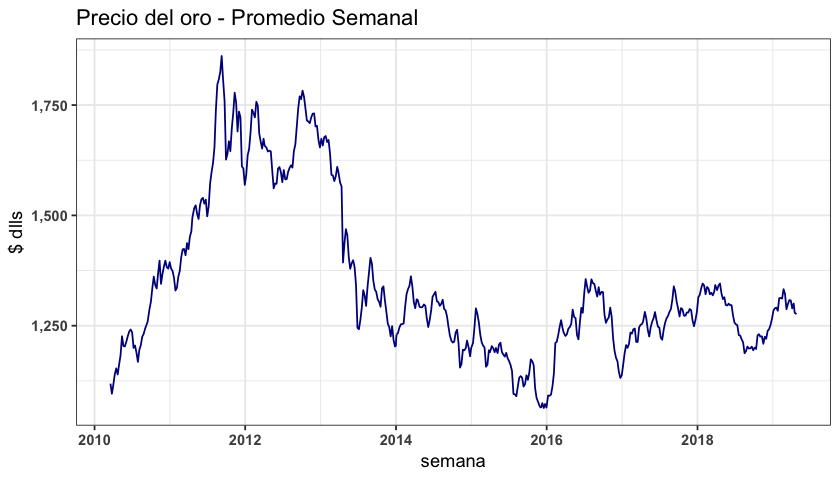

In [26]:
options(repr.plot.width=7, repr.plot.height=4)
data %>%
 ggplot() +
 geom_line(aes(x = max_date, y = avg_gold, group = 1), colour = 'darkblue') +
 theme_bw() +
 ggtitle('Precio del oro - Promedio Semanal') +
 theme(axis.text.x = element_text(face = 'bold'),
       axis.text.y = element_text(face = 'bold')) +
 scale_y_continuous(labels = scales::comma) +
 xlab('semana') +
 ylab('$ dlls')

## Correlaciones

Se obtendrán las correlaciones entre las variables de medias móviles, rezagos y rendimientos

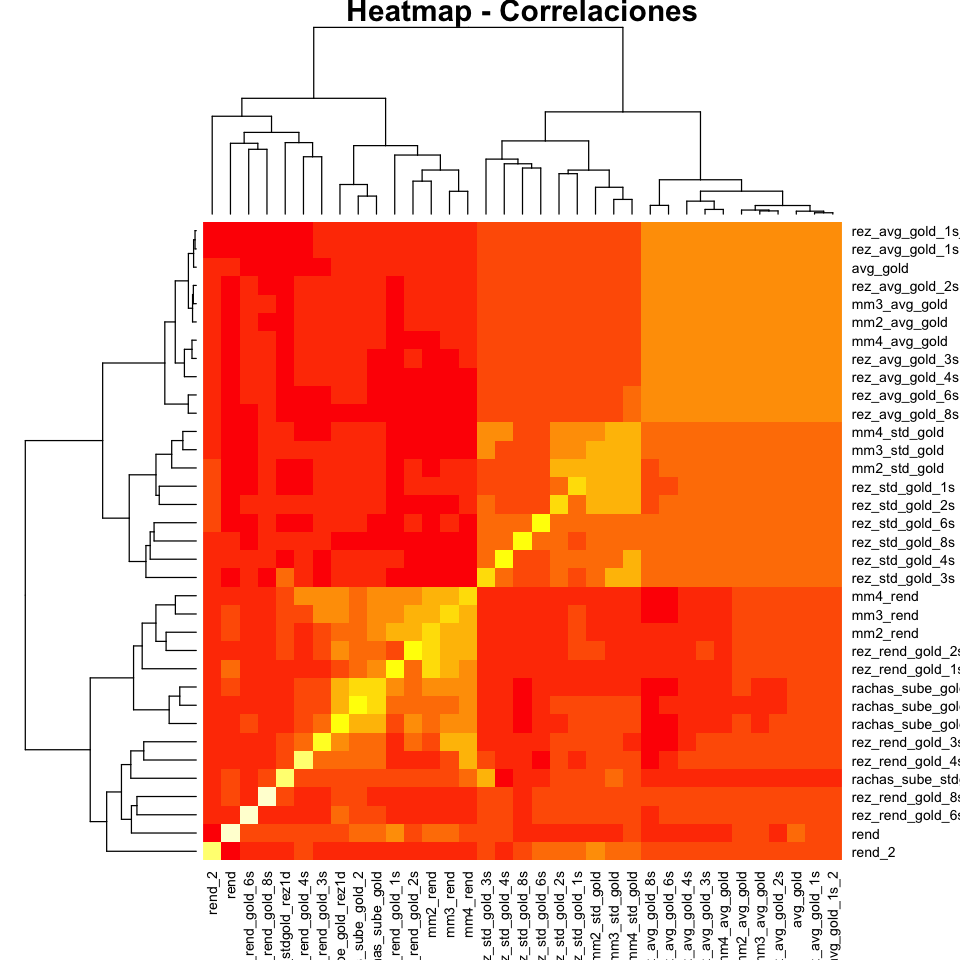

In [27]:
options(repr.plot.width=8, repr.plot.height=8)
data %>%
  select(-grep('mes', names(data))) %>%
 select(-week, -min_date, -max_date, -std_gold) %>%
 cor() %>%
 heatmap(main = 'Heatmap - Correlaciones')

## Promedio del oro vs Rezagos precio oro

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


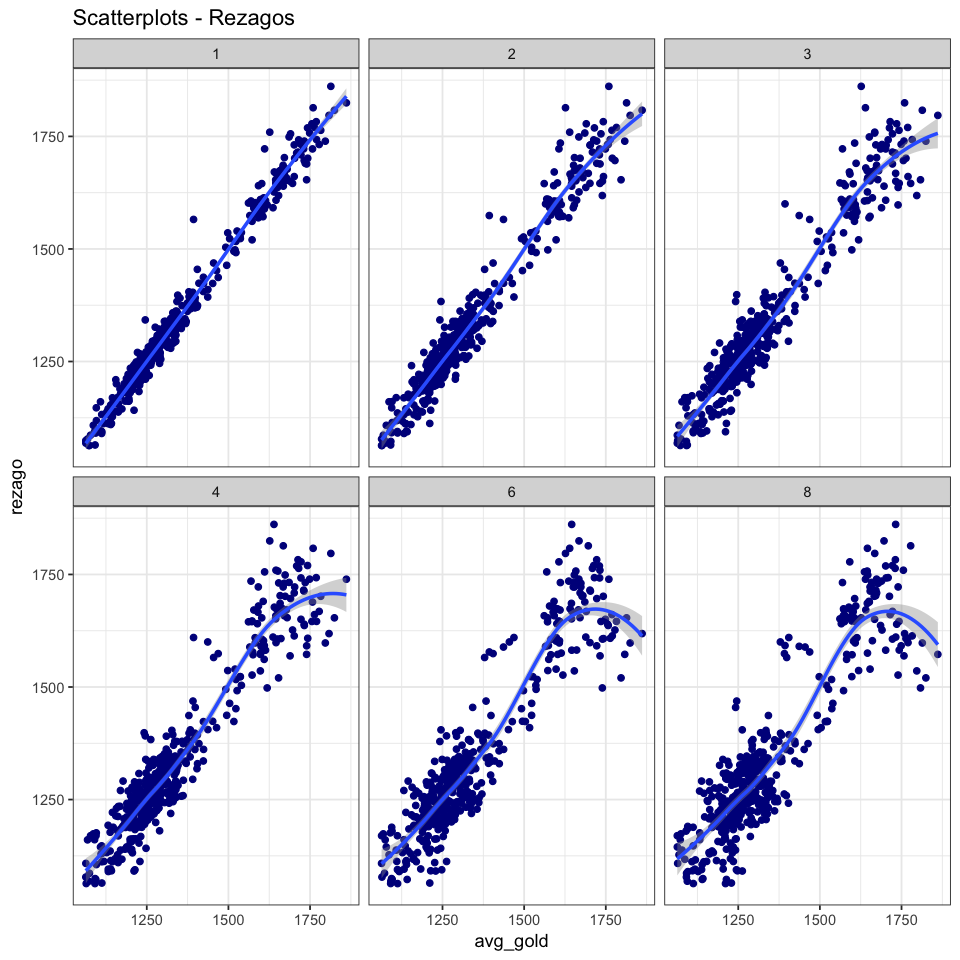

In [28]:
data.frame(avg_gold = rep(data$avg_gold,6),
           rezago   = c(data$rez_avg_gold_1s, data$rez_avg_gold_2s, data$rez_avg_gold_3s,
                        data$rez_avg_gold_4s, data$rez_avg_gold_6s, data$rez_avg_gold_8s),
           num_rezago = c(rep(1, nrow(data)), rep(2, nrow(data)), rep(3, nrow(data)),
                          rep(4, nrow(data)), rep(6, nrow(data)), rep(8, nrow(data)))) %>%
 ggplot() +
 geom_point(aes(x = avg_gold, y = rezago), colour = 'darkblue') +
 theme_bw() +
 ggtitle('Scatterplots - Rezagos') +
 facet_wrap(~num_rezago) +
 geom_smooth(aes(x = avg_gold, y = rezago))

## Promedio Oro vs Rendimientos

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


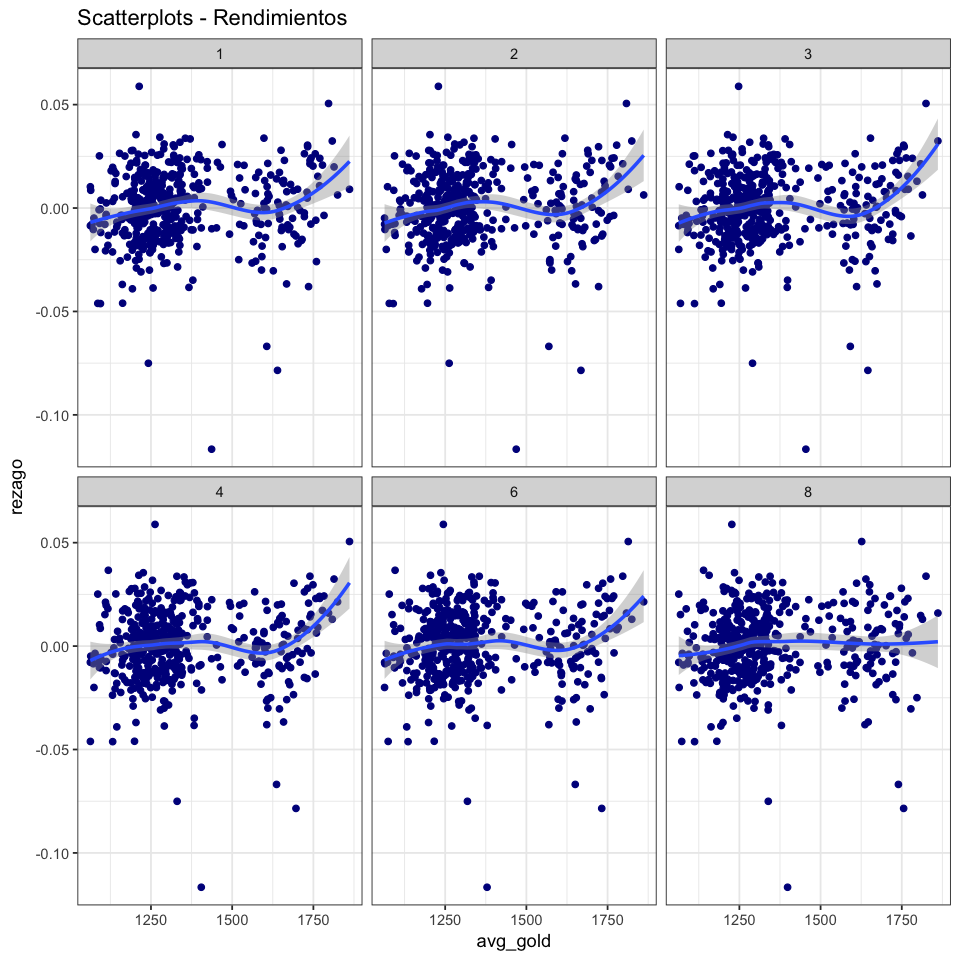

In [29]:
data.frame(avg_gold = rep(data$avg_gold,6),
           rezago   = c(data$rend, data$rez_rend_gold_1s, data$rez_rend_gold_2s,
                        data$rez_rend_gold_3s, data$rez_rend_gold_4s, data$rez_rend_gold_6s),
           num_rezago = c(rep(1, nrow(data)), rep(2, nrow(data)), rep(3, nrow(data)),
                          rep(4, nrow(data)), rep(6, nrow(data)), rep(8, nrow(data)))) %>%
 ggplot() +
 geom_point(aes(x = avg_gold, y = rezago), colour = 'darkblue') +
 theme_bw() +
 ggtitle('Scatterplots - Rendimientos') +
 facet_wrap(~num_rezago) +
 geom_smooth(aes(x = avg_gold, y = rezago))

# Modelo

Se hará un modelo de regresión lineal para estimar el valor del oro

$$PromedioPrecioOro_i = \alpha + \eta_1*MM2Oro_i + \eta_2*MM3Oro_i + \eta_3*MM4Oro_i + \eta_4*MM2RO_i + \eta_5*MM3RO_i + \eta_6*MM4RO_i + \eta_7*MM2SO_i + \eta8*MM3SO_i + \eta_9*MM4SO_i + \sum_j^{j\in\{1,2,3,4,6,8\}} \beta_j*RO_{j_i} + \sum_j^{j\in\{1,2,3,4,6,8\}} \delta_j*RezagoOro_{j_i} + \sum_j^{j\in\{1,2,3,4,6,8\}} \delta_j*RezagoSO_{j_i} + \sigma_j*DummieMes_{j_i} + \phi_1*RachaPO_i + \phi_2*RachaRO1_i + \phi_3*RachaRSD_i + \epsilon_i$$

Posteriormente se ajustará con un _stepwise_

Dónde:
 - **RO:** Rendimiento del oro
 - **MMi:** Media Móvile a "i" unidades de tiempo
 - **SO:** Desviación estándard del oro

## Fit

Se ajusta la regresión lineal

In [30]:
set.seed(50)
indices <- sample(1:nrow(data), nrow(data)*0.8)
train <- data[indices,]
valid <- data[-indices,]

In [31]:
names(data)

[1] "week"                      "min_date"                 
 [3] "max_date"                  "avg_gold"                 
 [5] "std_gold"                  "mes_Abr"                  
 [7] "mes_Ago"                   "mes_Dic"                  
 [9] "mes_Feb"                   "mes_Jul"                  
[11] "mes_Jun"                   "mes_Mar"                  
[13] "mes_May"                   "mes_Nov"                  
[15] "mes_Oct"                   "mes_Sep"                  
[17] "rend"                      "rez_avg_gold_1s"          
[19] "rez_avg_gold_2s"           "rez_avg_gold_3s"          
[21] "rez_avg_gold_4s"           "rez_avg_gold_6s"          
[23] "rez_avg_gold_8s"           "rez_std_gold_1s"          
[25] "rez_std_gold_2s"           "rez_std_gold_3s"          
[27] "rez_std_gold_4s"           "rez_std_gold_6s"          
[29] "rez_std_gold_8s"           "rez_rend_gold_1s"         
[31] "rez_rend_gold_2s"          "rez_rend_gold_3s"         
[33] "rez_rend_gold_4s"          "rez_rend_gold_6s"         
[35] "rez_rend_gold_8s"          "mm2_avg_gold"             
[37] "mm3_avg_gold"              "mm4_avg_gold"             
[39] "mm2_std_gold"              "mm3_std_gold"             
[41] "mm4_std_gold"              "mm2_rend"                 
[43] "mm3_rend"                  "mm4_rend"                 
[45] "rachas_sube_gold"          "rachas_sube_gold_rez1d"   
[47] "rachas_sube_stdgold_rez1d" "rez_avg_gold_1s_2"        
[49] "rend_2"                    "rachas_sube_gold_2"

In [32]:
m1 <- lm(avg_gold ~ ., data = train %>% select(-week, -min_date, -max_date, -std_gold))

In [33]:
m1 <- step(m1)

Start:  AIC=2469.69
avg_gold ~ mes_Abr + mes_Ago + mes_Dic + mes_Feb + mes_Jul + 
    mes_Jun + mes_Mar + mes_May + mes_Nov + mes_Oct + mes_Sep + 
    rend + rez_avg_gold_1s + rez_avg_gold_2s + rez_avg_gold_3s + 
    rez_avg_gold_4s + rez_avg_gold_6s + rez_avg_gold_8s + rez_std_gold_1s + 
    rez_std_gold_2s + rez_std_gold_3s + rez_std_gold_4s + rez_std_gold_6s + 
    rez_std_gold_8s + rez_rend_gold_1s + rez_rend_gold_2s + rez_rend_gold_3s + 
    rez_rend_gold_4s + rez_rend_gold_6s + rez_rend_gold_8s + 
    mm2_avg_gold + mm3_avg_gold + mm4_avg_gold + mm2_std_gold + 
    mm3_std_gold + mm4_std_gold + mm2_rend + mm3_rend + mm4_rend + 
    rachas_sube_gold + rachas_sube_gold_rez1d + rachas_sube_stdgold_rez1d + 
    rez_avg_gold_1s_2 + rend_2 + rachas_sube_gold_2


Step:  AIC=2469.69
avg_gold ~ mes_Abr + mes_Ago + mes_Dic + mes_Feb + mes_Jul + 
    mes_Jun + mes_Mar + mes_May + mes_Nov + mes_Oct + mes_Sep + 
    rend + rez_avg_gold_1s + rez_avg_gold_2s + rez_avg_gold_3s + 
    rez_avg_gol

## Coeficientes

### Summary

In [34]:
summary(m1)


Call:
lm(formula = avg_gold ~ mes_May + mes_Nov + rez_avg_gold_1s + 
    rez_avg_gold_4s + rez_avg_gold_8s + rez_std_gold_1s + rez_std_gold_6s + 
    rez_std_gold_8s + rez_rend_gold_1s + rez_rend_gold_2s + rachas_sube_gold + 
    rachas_sube_stdgold_rez1d + rend_2 + rachas_sube_gold_2, 
    data = train %>% select(-week, -min_date, -max_date, -std_gold))

Residuals:
     Min       1Q   Median       3Q      Max 
-167.137  -13.188    0.499   12.676   76.218 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  7.40167    9.77964   0.757 0.449630    
mes_May                     -9.36185    4.82313  -1.941 0.053022 .  
mes_Nov                     -7.33546    4.57926  -1.602 0.110043    
rez_avg_gold_1s              1.28961    0.05413  23.825  < 2e-16 ***
rez_avg_gold_4s             -0.34591    0.05671  -6.100 2.70e-09 ***
rez_avg_gold_8s              0.05150    0.02274   2.264 0.024150 *  
rez_std_gold_1s             -0.32865    

### Gráfica

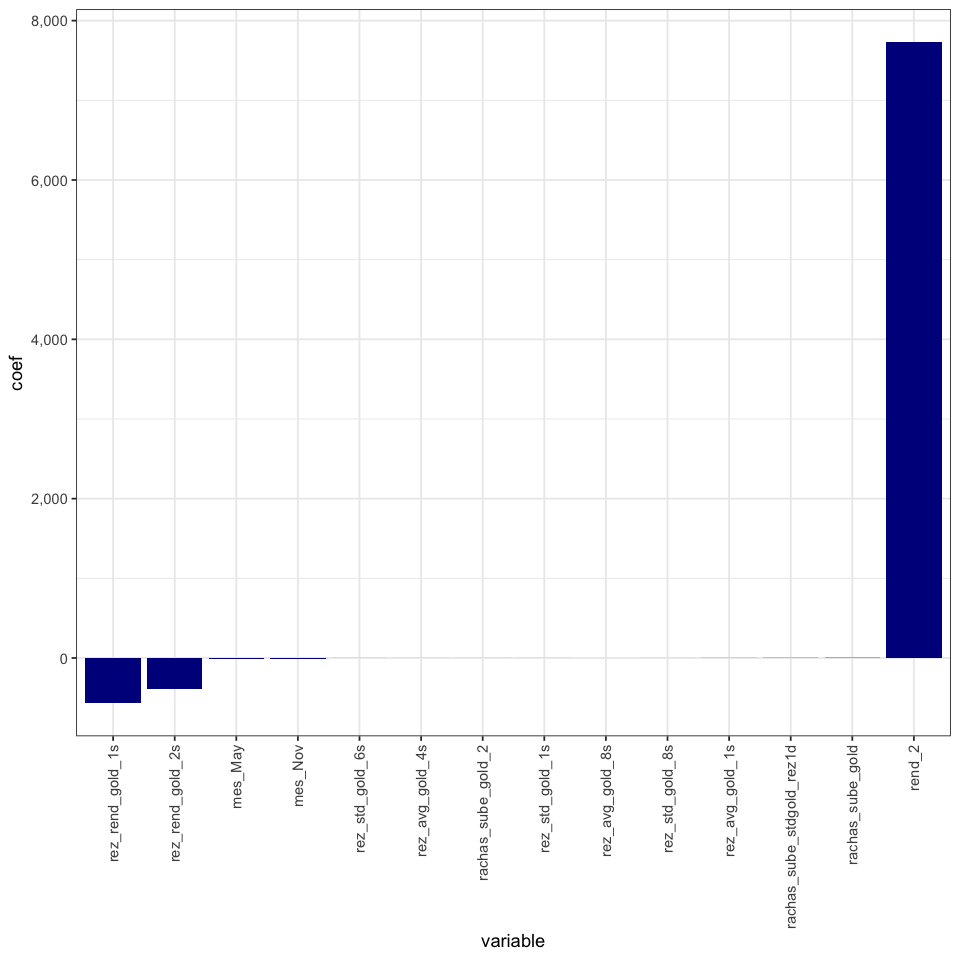

In [35]:
m1$coefficients %>%
 data.frame() %>%
 rename('coef' = '.') %>%
 mutate(variable = rownames(.)) %>%
 filter(variable != '(Intercept)') %>%
 filter(!is.na(coef)) %>%
 arrange(coef) %>%
 mutate(variable = fct_inorder(variable)) %>%
 ggplot() +
 geom_col(aes(x = variable, y = coef), fill = 'darkblue') +
 theme_bw() +
 scale_y_continuous(labels = scales::comma) +
 theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

## RMSE - Train & Valid

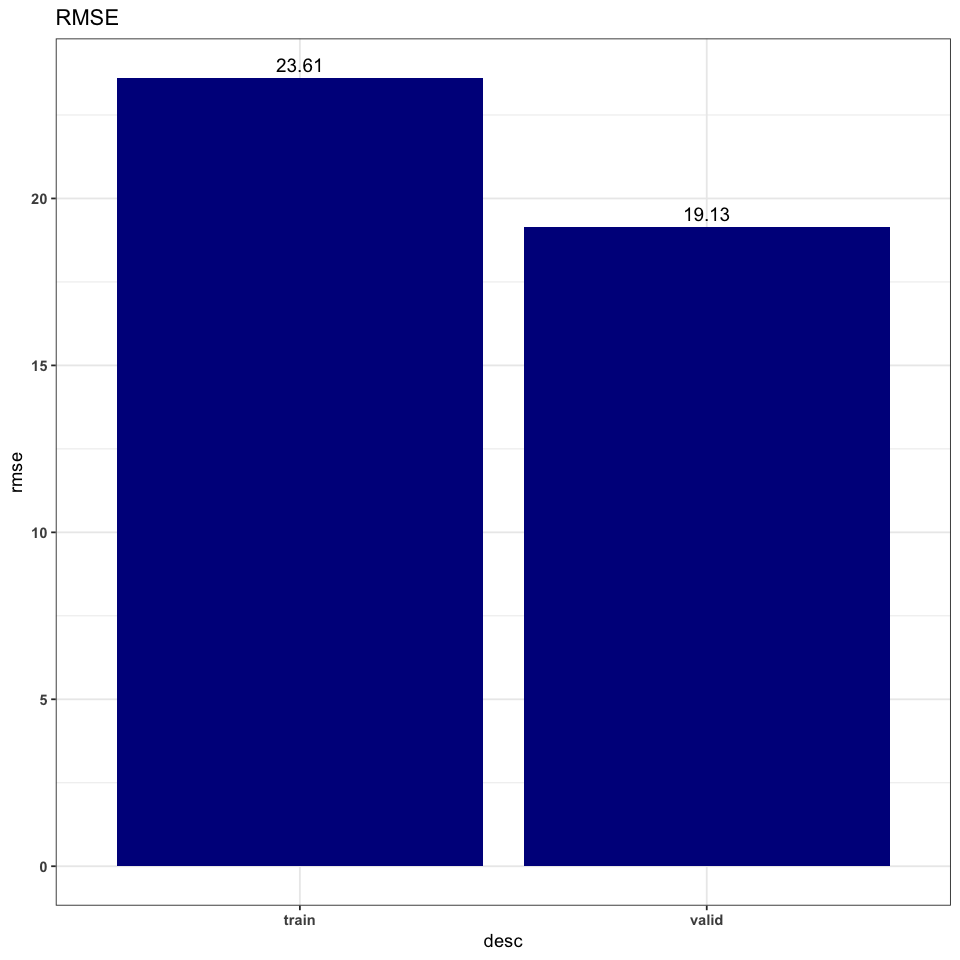

In [36]:
data.frame(desc = c('train', 'valid'),
           rmse = c(rmse(train$avg_gold, predict(m1, train)),
                    rmse(valid$avg_gold, predict(m1, valid)))) %>%
 ggplot() +
 geom_bar(aes(x = desc, y = rmse), stat = 'identity', fill = 'darkblue') +
 theme_bw() +
 ggtitle('RMSE') +
 theme(axis.text.x = element_text(face = 'bold'),
       axis.text.y = element_text(face = 'bold')) +
 geom_text(aes(x = desc, y = rmse, label = round(rmse,2)), vjust = -0.5, size = 4)

## Gráfico de errores

Gráfica de errores buscando que se comporte como ruido blanco _(es decir, sin alguna tendencia fuertemente perceptible)_

$$Error_i = PrecioOro_i - PrecioEstimado_i $$

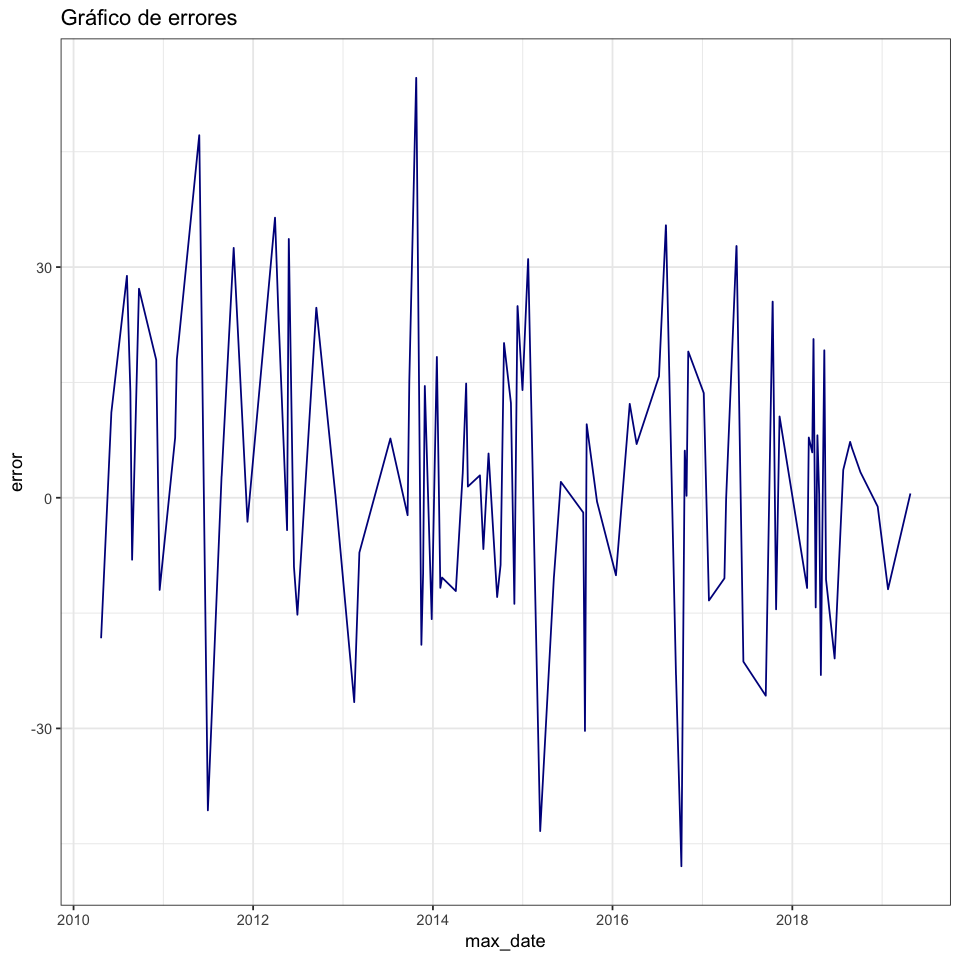

In [37]:
valid %>%
 mutate(pred = predict(m1, valid)) %>%
 mutate(error = avg_gold - pred) %>%
 ggplot() +
 geom_line(aes(x = max_date, y = error, group = 1), colour = 'darkblue') +
 theme_bw() +
 ggtitle('Gráfico de errores')

## Observado vs Estimado

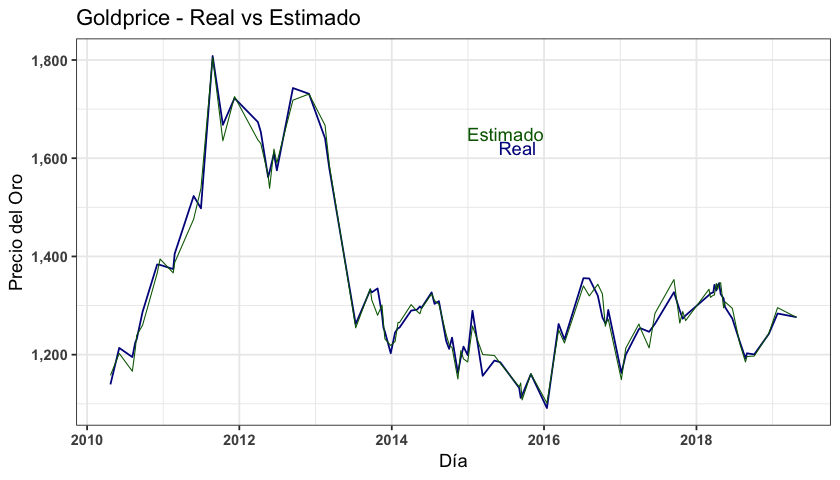

In [38]:
options(repr.plot.width=7, repr.plot.height=4)
valid %>%
 mutate(pred = predict(m1, valid)) %>%
 ggplot() +
 geom_line(aes(x = max_date, y = avg_gold, group = 1), colour = 'darkblue') +
 geom_line(aes(x = max_date, y = pred, group = 1), colour = 'darkgreen', size = 0.3) +
 theme_bw() +
 ggtitle('Goldprice - Real vs Estimado') + 
 scale_y_continuous(labels = scales::comma) +
 xlab('Día') +
 ylab('Precio del Oro') +
 theme(axis.text.x = element_text(face = 'bold'),
       axis.text.y = element_text(face = 'bold')) +
 annotate(geom  = 'text',
          x     = as.Date('2016-01-01'),
          y     = 1650,
          label = 'Estimado',
          colour = 'darkgreen',
          hjust = 1) +
 annotate(geom  = 'text',
          x     = as.Date('2016-01-01'),
          y     = 1620,
          label = 'Real',
          colour = 'darkblue',
          hjust = 1.2)

# Predicción

Se hará la predicción del promedio del precio del oro de una semana después de la última registrada.

Para crear el _data frame_ para la predicción, los _rezagos_ serán equivalentes al _rezago - 1_ de los usados para crear el _data frame_ de _train_, ya que aquí se busco que el "último rezago" se la última observación.

## Lectura de datos

Se leen de nuevo los datos para crear el _data frame_ para _predict_

In [39]:
gold_pred <- read_csv("/Users/darias/Documents/GoldPrice/Data/WGC-GOLD_DAILY_USD.csv")
names(gold_pred) <- c('date', 'goldprice')

dolar_pred <- read_csv("/Users/darias/Documents/GoldPrice/Data/Consulta_20190502-142917176.csv", 
    skip = 17)
names(dolar_pred) <- c('date', 'dolarprice')
dolar_pred %>%
 mutate(date = paste0(substr(date,7,10),
                     '-',
                     substr(date,4,5),
                     '-',
                     substr(date,1,2))) %>%
 mutate(date = as.Date(date)) -> dolar_pred

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Value = col_double()
)
Parsed with column specification:
cols(
  Fecha = col_character(),
  SF63528 = col_double()
)


## Homologación de datos

In [40]:
max_date <- min(max(gold_pred$date), max(dolar_pred$date))
min_date <- max(min(gold_pred$date), min(dolar_pred$date))

dolar_pred %>%
 filter(date >= min_date) %>%
 filter(date <= max_date) -> dolar_pred

gold_pred %>%
 filter(date >= min_date) %>%
 filter(date <= max_date) -> gold_pred

max_date <- min(max(gold_pred$date), max(dolar_pred$date))
min_date <- max(min(gold_pred$date), min(dolar_pred$date))

dolar_pred %>%
 filter(date >= min_date) %>%
 filter(date <= max_date) -> dolar_pred

gold_pred %>%
 filter(date >= min_date) %>%
 filter(date <= max_date) -> gold_pred

## Juntar datos

In [41]:
dolar_pred %>%
 left_join(gold_pred, by = 'date') %>%
 select(-dolarprice) -> data_pred

## Limpiar datos

In [42]:
data_pred %>%
 filter(!is.na(goldprice)) -> data_pred

Se dejarán datos a partir del 2015

In [43]:
data_pred %>%
 filter(date >= as.Date('2015-01-01')) -> data_pred

## Promedio Semanal

In [44]:
data_pred %>%
 mutate(week = paste0(year(date),'-',format(date, '%W'))) %>%
 group_by(week) %>%
 summarise(min_date = min(date),
           max_date = max(date),
           avg_gold = mean(goldprice, na.rm = TRUE),
           std_gold = sd(goldprice, na.rm = TRUE)) %>%
 arrange(as.numeric(gsub('-','',week))) %>%
 filter(!is.na(std_gold)) %>%
 mutate(mes = month(max_date)) %>%
 mutate(mes = ifelse(mes == 1, 'Ene', mes),
        mes = ifelse(mes == 2, 'Feb', mes),
        mes = ifelse(mes == 3, 'Mar', mes),
        mes = ifelse(mes == 4, 'Abr', mes),
        mes = ifelse(mes == 5, 'May', mes),
        mes = ifelse(mes == 6, 'Jun', mes),
        mes = ifelse(mes == 7, 'Jul', mes),
        mes = ifelse(mes == 8, 'Ago', mes),
        mes = ifelse(mes == 9, 'Sep', mes),
        mes = ifelse(mes == 10, 'Oct', mes),
        mes = ifelse(mes == 11, 'Nov', mes),
        mes = ifelse(mes == 12, 'Dic', mes)) -> data_pred

## Rendimientos del oro

In [45]:
data_pred <- rend_func(data_pred, 'avg_gold', 'rend', ind_train = FALSE)

## Rezagos

In [46]:
data_pred <- rez_func(data_pred, 'avg_gold', 'rez_avg_gold_1s',  1,  FALSE)
data_pred <- rez_func(data_pred, 'avg_gold', 'rez_avg_gold_2s',  2,  FALSE)
data_pred <- rez_func(data_pred, 'avg_gold', 'rez_avg_gold_3s',  3,  FALSE)
data_pred <- rez_func(data_pred, 'avg_gold', 'rez_avg_gold_4s',  4,  FALSE)
data_pred <- rez_func(data_pred, 'avg_gold', 'rez_avg_gold_6s',  6,  FALSE)
data_pred <- rez_func(data_pred, 'avg_gold', 'rez_avg_gold_8s',  8,  FALSE)

In [47]:
data_pred <- rez_func(data_pred, 'std_gold', 'rez_std_gold_1s',  1,  FALSE)
data_pred <- rez_func(data_pred, 'std_gold', 'rez_std_gold_2s',  2,  FALSE)
data_pred <- rez_func(data_pred, 'std_gold', 'rez_std_gold_3s',  3,  FALSE)
data_pred <- rez_func(data_pred, 'std_gold', 'rez_std_gold_4s',  4,  FALSE)
data_pred <- rez_func(data_pred, 'std_gold', 'rez_std_gold_6s',  6,  FALSE)
data_pred <- rez_func(data_pred, 'std_gold', 'rez_std_gold_8s',  8,  FALSE)

In [48]:
data_pred <- rez_func(data_pred, 'rend', 'rez_rend_gold_1s',  1,  FALSE)
data_pred <- rez_func(data_pred, 'rend', 'rez_rend_gold_2s',  2,  FALSE)
data_pred <- rez_func(data_pred, 'rend', 'rez_rend_gold_3s',  3,  FALSE)
data_pred <- rez_func(data_pred, 'rend', 'rez_rend_gold_4s',  4,  FALSE)
data_pred <- rez_func(data_pred, 'rend', 'rez_rend_gold_6s',  6,  FALSE)
data_pred <- rez_func(data_pred, 'rend', 'rez_rend_gold_8s',  8,  FALSE)

## Medias Móviles

In [49]:
data_pred <- mm_func(data_pred, 'avg_gold', 'mm2_avg_gold', 2, TRUE)
data_pred <- mm_func(data_pred, 'avg_gold', 'mm3_avg_gold', 3, TRUE)
data_pred <- mm_func(data_pred, 'avg_gold', 'mm4_avg_gold', 4, TRUE)

data_pred <- mm_func(data_pred, 'std_gold', 'mm2_std_gold', 2, TRUE)
data_pred <- mm_func(data_pred, 'std_gold', 'mm3_std_gold', 3, TRUE)
data_pred <- mm_func(data_pred, 'std_gold', 'mm4_std_gold', 4, TRUE)

data_pred <- mm_func(data_pred, 'rend', 'mm2_rend', 2, TRUE)
data_pred <- mm_func(data_pred, 'rend', 'mm3_rend', 3, TRUE)
data_pred <- mm_func(data_pred, 'rend', 'mm4_rend', 4, TRUE)

## Rachas

In [50]:
data_pred <- racha(data_pred, 'avg_gold', 'rachas_sube_gold', FALSE)
data_pred <- racha(data_pred, 'rez_avg_gold_1s', 'rachas_sube_gold_rez1d', FALSE)
data_pred <- racha(data_pred, 'rez_std_gold_1s', 'rachas_sube_stdgold_rez1d', FALSE)

## Dummies mes

In [51]:
data_pred %>%
 mutate(mes = as.factor(mes)) -> data_pred

one_hot(as.data.table(data_pred)) %>%
 as.data.frame -> data_pred

## Cuadrados

In [52]:
data_pred %>%
 mutate(rez_avg_gold_1s_2 = rez_avg_gold_1s^2,
        rend_2 = rend^2,
        rachas_sube_gold_2 = rachas_sube_gold^2,
        rez_avg_gold_8s_2 = rez_avg_gold_8s^2) -> data_pred

## Se quitan NA's

In [53]:
data_pred %>%
 filter(!is.na(rez_avg_gold_8s)) %>%
 filter(!is.na(rez_rend_gold_8s)) -> data_pred

## Pronóstico vs Observado

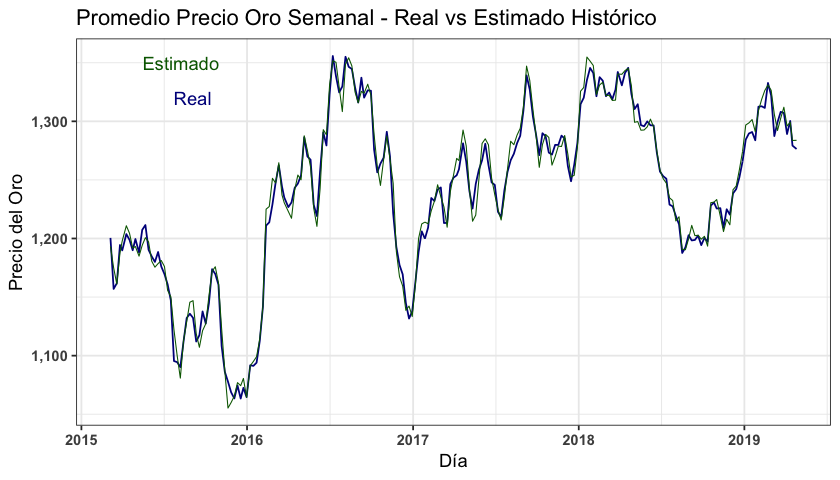

In [54]:
options(repr.plot.width=7, repr.plot.height=4)
data_pred %>%
 mutate(pred = predict(m1, data_pred)) %>%
 ggplot() +
 geom_line(aes(x = max_date, y = avg_gold, group = 1), colour = 'darkblue') +
 geom_line(aes(x = max_date, y = pred, group = 1), colour = 'darkgreen', size = 0.3) +
 theme_bw() +
 ggtitle('Promedio Precio Oro Semanal - Real vs Estimado Histórico') + 
 scale_y_continuous(labels = scales::comma) +
 xlab('Día') +
 ylab('Precio del Oro') +
 theme(axis.text.x = element_text(face = 'bold'),
       axis.text.y = element_text(face = 'bold')) +
 annotate(geom  = 'text',
          x     = as.Date('2015-11-01'),
          y     = 1350,
          label = 'Estimado',
          colour = 'darkgreen',
          hjust = 1) +
 annotate(geom  = 'text',
          x     = as.Date('2015-11-01'),
          y     = 1320,
          label = 'Real',
          colour = 'darkblue',
          hjust = 1.2)

## Predicción siguiente semana

In [55]:
sp <- predict(m1, tail(data_pred,1))
paste0('Predicción Promedio Oro siguiente semana',
       ' : ',
       sp
       )

[1] "Predicción Promedio Oro siguiente semana : 1283.80309083262"

## Precio Promedio semana actual

In [56]:
#sa <- predict(m1, data_pred[nrow(data_pred)-2,])
sa <- tail(data_pred$avg_gold,1)
paste0('Predicción Promedio Oro Semana actual',
       ' : ',
       sa)

[1] "Predicción Promedio Oro Semana actual : 1276.37"

## Resumen Pronóstico

In [57]:
# RMSE del modelo en validación
rmse_valid <- rmse(valid$avg_gold, predict(m1, valid))

# Indicador de alta o baja: pronosticado proxima semana vs semana actual
if(sp >= sa){
    a <- 'subida'
    r    <- abs((sp)/(sa))-1
} else {
    a <- 'bajada'
    r    <- 1-abs((sp)/(sa))
}

# Intervalo de confianza inferior
if((sp-rmse_valid)/(sa) >= 1){
    II <- (sp-rmse_valid)/(sa)-1
} else {
    II <- 1-(sp-rmse_valid)/(sa)
}

# Intervalo de confianza superior
if((sp+rmse_valid)/(sa) >= 1){
    IS <- (sp+rmse_valid)/(sa)-1
} else {
    IS <- 1-(sp+rmse_valid)/(sa)
}

# Indicador de alta o baja de intervalo inferior
if(sp-rmse_valid>=sa){
    ai <- 'subir'
} else {
    ai <- 'bajar'
}

# Indicador de alta o baja de intervalo superior
if(sp+rmse_valid>=sa){
    as <- 'subir'
} else {
    as <- 'bajar'
}

In [58]:
t0 <- paste0('La semana del ', tail(data_pred$min_date,1), ' al ', tail(data_pred$max_date,1), ' tuvo un precio promedio de: $', tail(data_pred$avg_gold,1), ' dlls')
t1 <- paste0('Para la próxima semana, se pronostica un valor promedio del oro de: $', round(sp,2), ' dlls')
t2 <- paste0('Lo cuál indicaría una ', a, ' del ', round(r*100,2), '% respecto a esta semana')
t3 <- paste0('Pero podría ', ai, ' de ', round(II*100,2), '%', ' a ', as, ' ', round(IS*100,2), '%')

In [59]:
data.frame(. = c(t0,t1,t2,t3))

.                                                                               
1 La semana del 2019-04-22 al 2019-04-26 tuvo un precio promedio de: $1276.37 dlls
2 Para la próxima semana, se pronostica un valor promedio del oro de: $1283.8 dlls
3 Lo cuál indicaría una subida del 0.58% respecto a esta semana                   
4 Pero podría bajar de 0.92% a subir 2.08%